# 패키지 불러오기

In [1]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Okt
import pandas as pd
import enum
import os
import re

from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [2]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로 정의

In [3]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 로드

In [5]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

## 모델 만들기에 필요한 값 선언

In [6]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
# BATCH_SIZE = 64
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1 

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

# 모델 

## 인코더

In [7]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim          
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x)#, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self, batch_sz=None):
        if batch_sz is None:
            batch_sz = self.batch_sz
        return tf.zeros((batch_sz, self.enc_units))

## 어텐션

In [8]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        hidden_with_time_axis = tf.expand_dims(query, 1)

        score = self.V(tf.nn.tanh(
            self.W1(values) + self.W2(hidden_with_time_axis)))

        attention_weights = tf.nn.softmax(score, axis=1)

        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

## 디코더

In [9]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.vocab_size = vocab_size 
        self.embedding_dim = embedding_dim  
        
        self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc = tf.keras.layers.Dense(self.vocab_size)

        self.attention = BahdanauAttention(self.dec_units)
        
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)

        x = self.embedding(x)

        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
            
        x = self.fc(output)
        
        return x, state, attention_weights

In [10]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    print(pred)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

## 시퀀스 투 스퀀스 모델

In [11]:
class seq2seq(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_sz, end_token_idx=2):    
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_sz) 
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_sz) 

    def call(self, x):
        inp, tar = x

        enc_hidden = self.encoder.initialize_hidden_state()
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32) 
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))   
        return tf.stack(predict_tokens, axis=1)
    
    def inference(self, x):
        inp  = x
        
        enc_hidden = self.encoder.initialize_hidden_state(batch_sz=1)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([STD_INDEX], 1)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax(predictions[0])
            
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)   
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [12]:
model = seq2seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=tf.keras.optimizers.Adam(1e-3), metrics=[accuracy])

In [13]:
index_inputs.shape

(20, 25)

## 학습 진행

In [14]:
PATH = DATA_OUT_PATH + MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))
        
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH)
#                     validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

Tensor("seq2seq/Identity:0", shape=(None, 25, 111), dtype=float32)
Train on 20 samples
Epoch 1/30
Tensor("seq2seq/stack:0", shape=(2, 25, 111), dtype=float32)
Tensor("seq2seq/stack:0", shape=(2, 25, 111), dtype=float32)
20/20 [==============================] - 44s 2s/sample - loss: 0.8214 - accuracy: 0.8422
Epoch 2/30
20/20 [==============================] - 8s 418ms/sample - loss: 0.7280 - accuracy: 0.8568
Epoch 3/30
20/20 [==============================] - 10s 479ms/sample - loss: 0.6602 - accuracy: 0.8564
Epoch 4/30
20/20 [==============================] - 10s 493ms/sample - loss: 0.6115 - accuracy: 0.8565
Epoch 5/30
20/20 [==============================] - 9s 444ms/sample - loss: 0.5558 - accuracy: 0.8570
Epoch 6/30
20/20 [==============================] - 9s 462ms/sample - loss: 0.4987 - accuracy: 0.8588
Epoch 7/30
20/20 [==============================] - 9s 465ms/sample - loss: 0.4397 - accuracy: 0.8611
Epoch 8/30
20/20 [==============================] - 9s 431ms/sample - loss: 0

## 결과 플롯

KeyError: 'val_accuracy'

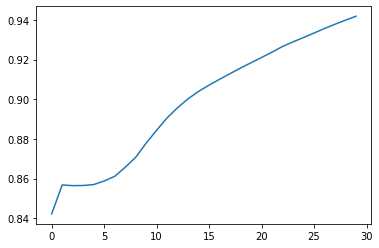

In [15]:
plot_graphs(history, 'accuracy')

In [ ]:
plot_graphs(history, 'loss')

### Evaluate

In [ ]:
SAVE_FILE_NM = "./data_out/seq2seq_kor/"
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NM))

In [16]:
query = "가끔 궁금해"

test_index_inputs, _ = enc_processing([query], char2idx, tokenize_as_morph=False)    
print(test_index_inputs)
predict_tokens = model.inference(test_index_inputs)
print(predict_tokens)

print(' '.join([idx2char[str(t)] for t in predict_tokens]))

[[76 95  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0]]
[36 56 79 11]
그 사람도 그럴 거예요
